<a href="https://colab.research.google.com/github/yuncongy/Seoul-Bike-Demand-Prediction/blob/main/SeoulBikeData_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
from sklearn.linear_model import LinearRegression

### Dataset
Using dataset from https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

Source: Seoul Bike Sharing Demand [Dataset]. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity","wind","visibility", "dew_pt_temp", "radiation","rainfall","snowfall","functional"]

Mainly focus on feature vectors like temperature, humidity... discarding features vectores related to dates/seasons since it will not fit the linear model I am trying to do here.

In [ ]:
df = pd.read_csv("SeoulBikeData.csv").drop(["Date","Seasons","Holiday"], axis=1)
df.columns = dataset_cols  # change the column names
df["functional"] = (df["functional"] == "Yes").astype(int)  # change Yes to value 1
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rainfall,snowfall,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


# Plot current data frame

First. I need to see the data. Each of the feature vs bike_count. This can help me better determine which of those feature mentioned will likely have a linear relationship.

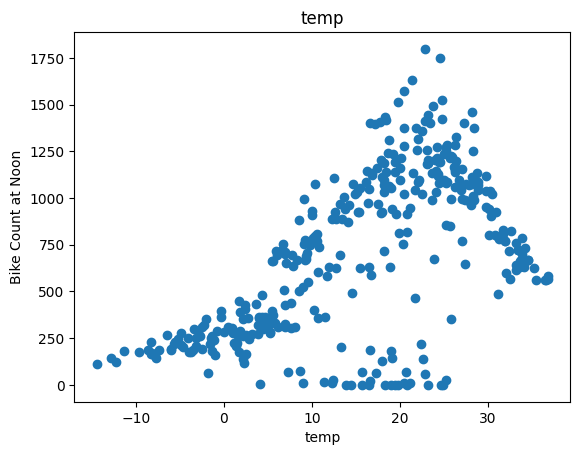

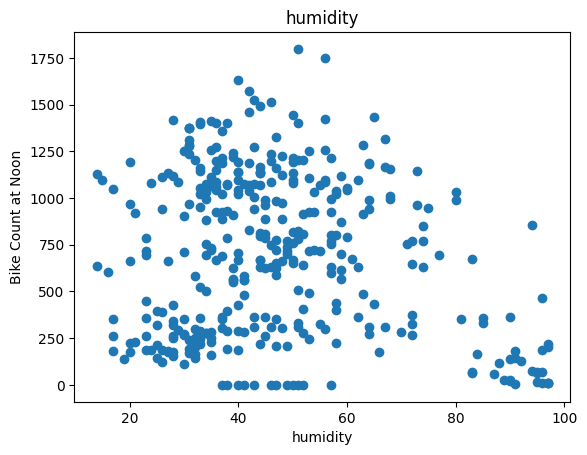

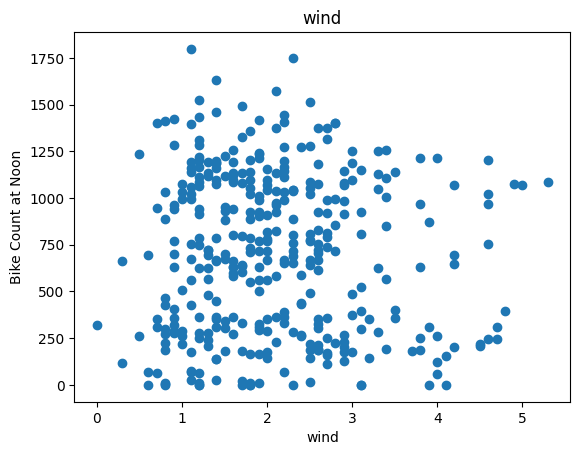

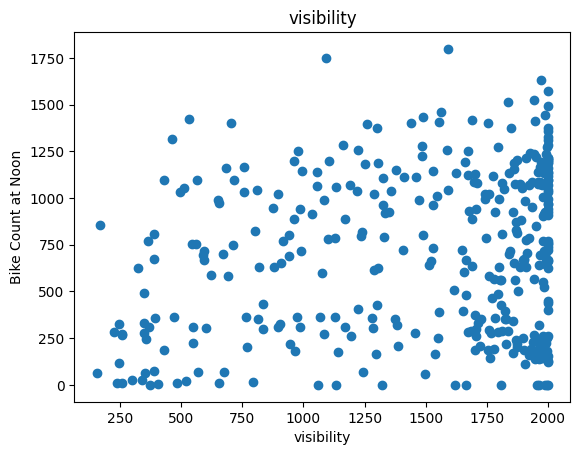

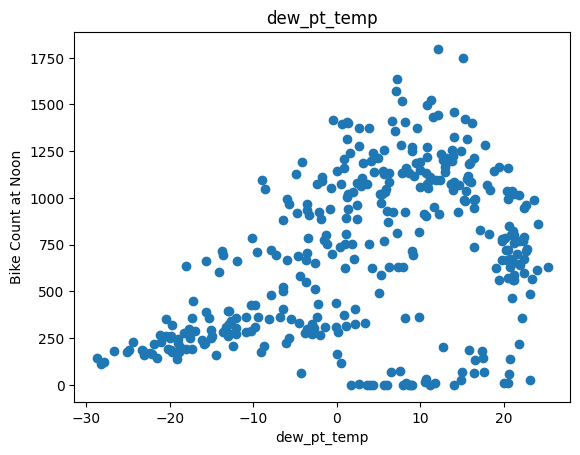

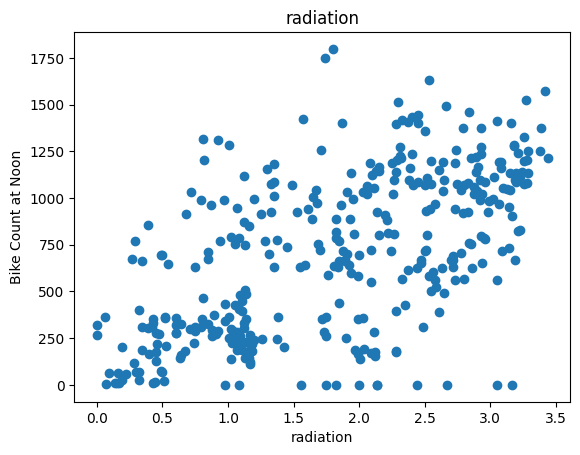

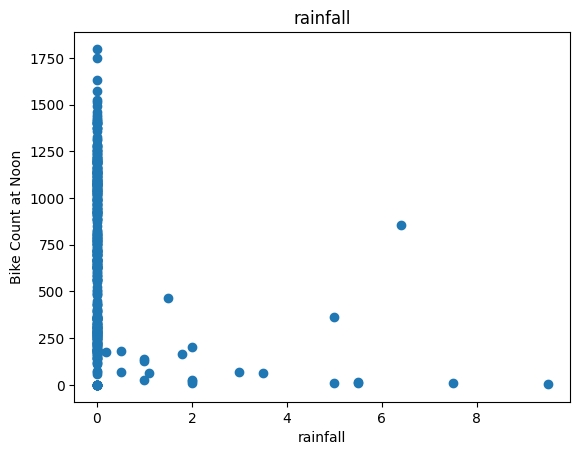

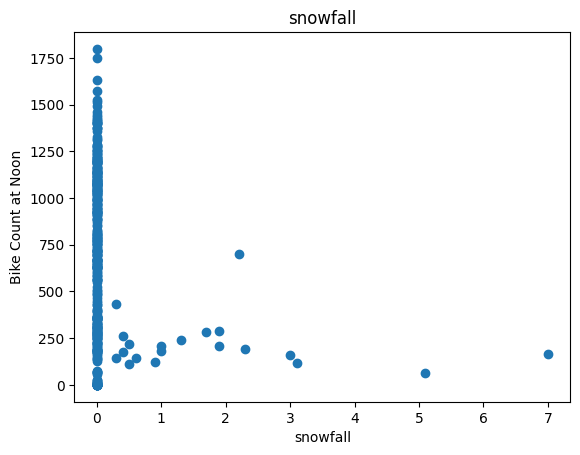

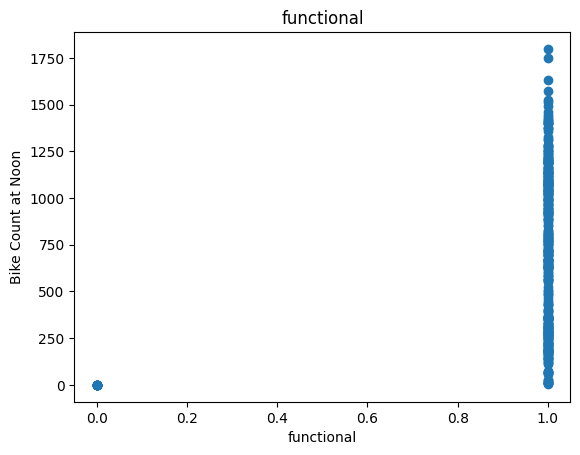

In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

By looking at the plots, there are a few data columns that can possibly be represented by a linear relation. Such as temp, humidity, dew_pt_temp, radiation.   
After viewing the plots, I am going to drop some data columns that clearly do not show a linear relationship. Such as wind, visibility, funcional.

In [ ]:
df = df.drop(["wind", "visibility", "functional"], axis = 1)

# Train/Validation/Test Dataset

Spliting dataset into: 60% Training data, 20% Validation, 20% Test.

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
# function to get X and y values from df
def get_xy(dataframe, y_label, x_label = None):
  dataframe = copy.deepcopy(dataframe)
  if x_label is None:
    X = dataframe[[c for c in dataframe.columns if c!= y_label]].values
  else:
    if len(x_label) == 1:
      X = dataframe[x_label[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_label].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

Let's try a Linear Regression model on temperature feature vector and see how it behaves.

Choosing temp data column because it best shows a linear relation between temp and bike_count. Temp might be a good predictor.

In [ ]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_label=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_label=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_label=["temp"])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [ ]:
print(temp_reg.coef_, temp_reg.intercept_)

[[20.33146809]] [384.47340329]


In [ ]:
temp_reg.score(X_test_temp, y_test_temp) # R^2, higher better

0.2721270437554234

### Get a line of best fit from this training data

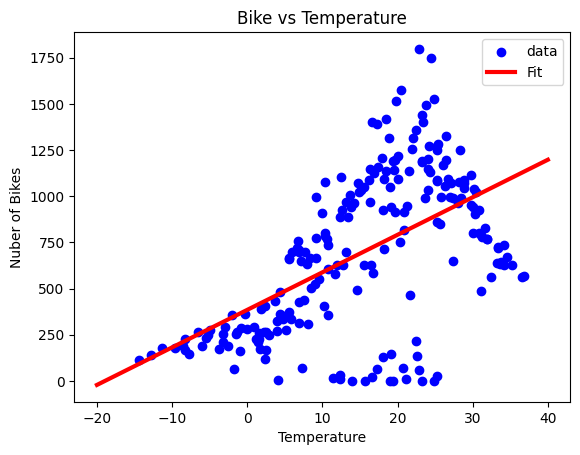

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label = "data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs Temperature")
plt.ylabel("Nuber of Bikes")
plt.xlabel("Temperature")
plt.show()

# Multiple Linear Regression

Now we use MLR and apply all of the feature vectors into the linear regression model.

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_label=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_label=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_label=df.columns[1:])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [ ]:
all_reg.score(X_test_all, y_test_all)

0.4078787019293363

This score should improve since we trained it on more data

# Regression with Neural Net

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1, ), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Create a tf model.   
Only use one layer because we want the output to be linear. With no Activation Function.

In [ ]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose = 0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label='validation_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE(Mean Squared Error)')
  plt.legend()
  plt.grid(True)
  plt.show()


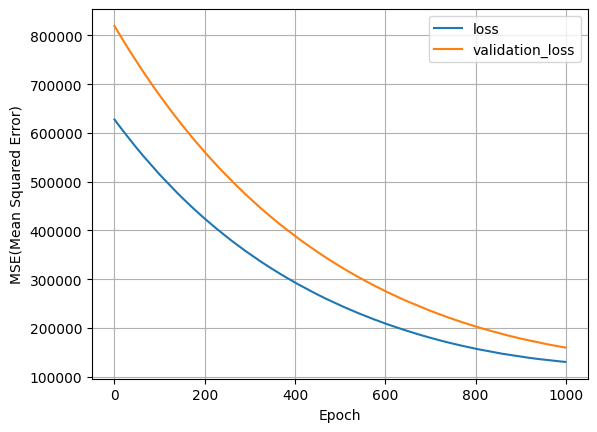

In [ ]:
plot_loss(history)

Values are converging.
Lets check fit using the nn regressor.   
 Copying plot from above.   

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


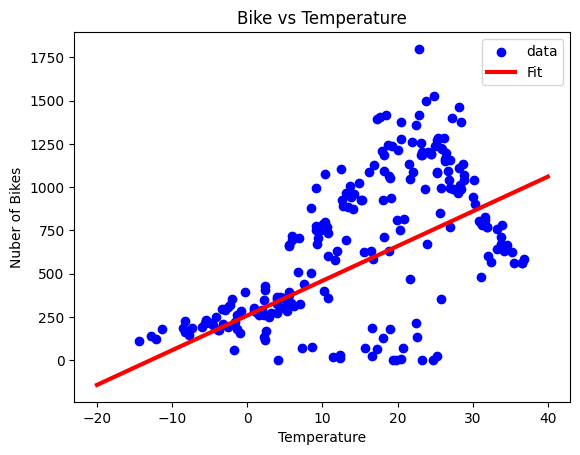

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label = "data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs Temperature")
plt.ylabel("Nuber of Bikes")
plt.xlabel("Temperature")
plt.show()

Fit line looks a bit different.

# Exercise: train all data

# Neural Net (multiple cell/nodes, layers)

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1, ), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0,
    epochs=100
)

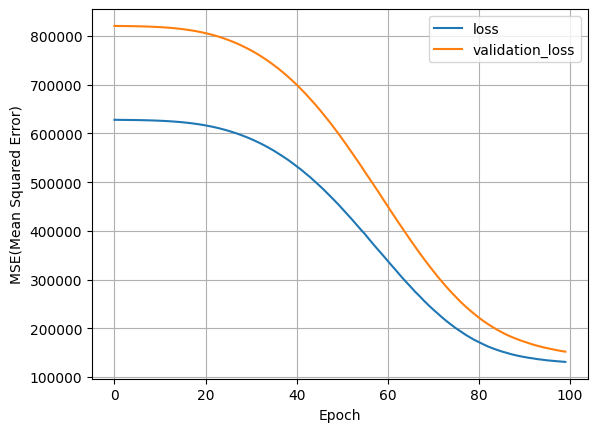

In [ ]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


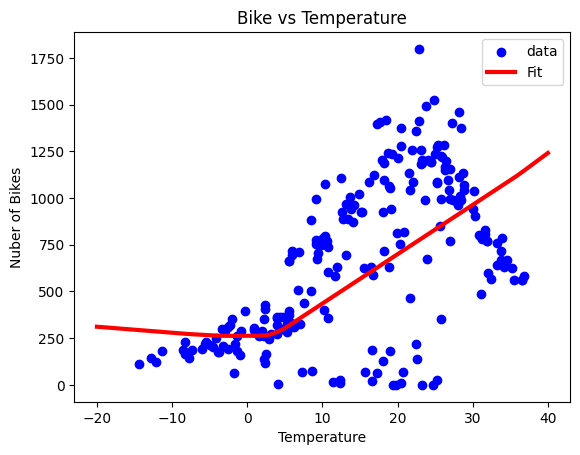

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label = "data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs Temperature")
plt.ylabel("Nuber of Bikes")
plt.xlabel("Temperature")
plt.show()

Not a good model, need to tweak the model a bit.Notice ther are very few data points when temp is below -10.   
This is no longer a linear model.

### Above is using NN only with Temp VS Bike_count.  
This time we use all of the data.

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0,
    epochs=100
)

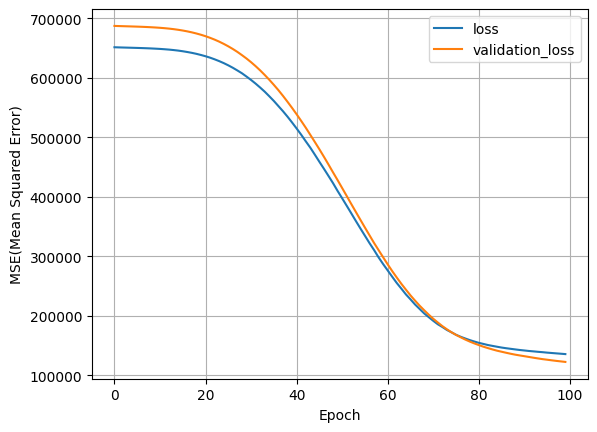

In [ ]:
plot_loss(history)

### Calculate the MSE for both linear reg and NN

In [ ]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

Compare MSE linear regression and Nerual Net

In [ ]:
MSE(y_pred_lr, y_test_all)

105904.88622861847

In [ ]:
MSE(y_pred_nn, y_test_all)

132112.96597347784

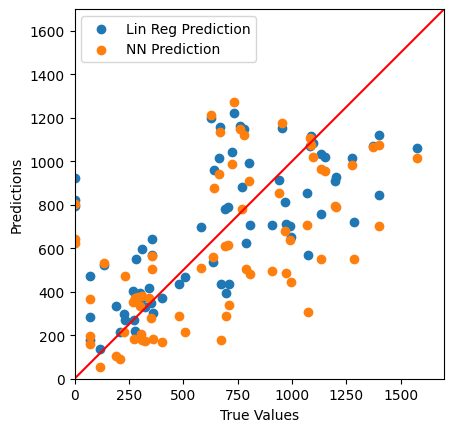

In [ ]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Prediction")
plt.scatter(y_test_all, y_pred_nn, label="NN Prediction")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1700]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")

Conclusion: In this dataset, a linear regressor model might work better than my NN model.